In [1]:
#!pip install cartopy
#!pip install geopandas=="0.13.2"
#!pip install fiona==1.9.6
import sys
sys.path.append("..")
from evaluation.Evaluation.Evaluation_Time_Series_Models import evaluate_results

#from src.utils import  heatmap,plot_heatmap,friedman_aligned_ranks_test,post_hoc_procedures,
from src.utils import  heatmap,pairwise_benchmark_vs_patchtst_friedman_aligned,visualize_smape_geomaps


import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import pickle
from permetrics import RegressionMetric
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import geopandas as gpd
import seaborn

### **1. Evaluate Results and Save in a DataFrame**

In [2]:
#Create a dict with the mapping of the country names and their indices in the sequences: 
EU_countries=['Austria','Belgium','Bulgaria','Croatia','Czechia','Denmark','Estonia','Finland','France',
             'Germany','Greece','Hungary','Italy','Latvia','Lithuania','Luxembourg',
             'Netherlands','Norway','Poland','Portugal','Romania','Serbia',
              'Slovakia','Slovenia','Spain','Sweden','Switzerland']
EU_countries_dict={}
for EU_country_idx in range(0,len(EU_countries)):
    EU_countries_dict[EU_country_idx]=EU_countries[EU_country_idx]
    
#Create a dictionary for storing the sequence predictions, which will be later used for the visualization of the 
#classical time series plots:
sequence_predictions={}
for country in ["Germany","France","Latvia","Luxembourg","Italy","Portugal"]:
    sequence_predictions[country]={"PatchTST":{"Train_Test1":{},"Train_Test2":{},"Train_Test3":{},"Train_Test4":{},"Train_Test5":{},"Train_Test6":{}},
                                   "TimesFM":{"Train_Test1":{},"Train_Test2":{},"Train_Test3":{},"Train_Test4":{},"Train_Test5":{},"Train_Test6":{}}}

In [4]:
#Save all results in a dataframe:
timeSeries_benchmark_results=evaluate_results(sequence_predictions=sequence_predictions,EU_countries_dict=EU_countries_dict)
timeSeries_benchmark_results.head(10)

,Time_Series_Model,TrainTest_Subset,Sequence_MiniBatch_Index,EU_Country,Achieved_RMSE,Achieved_MAE,Achieved_MSE,Achieved_SMAPE,Achieved_R2
0,PatchTST,Train_Test1,0,Austria,33.860984,28.319511,1146.566256,0.105881,-1.927360
1,PatchTST,Train_Test1,0,Belgium,37.566602,32.028918,1411.249549,0.118929,-4.602730
2,PatchTST,Train_Test1,0,Bulgaria,30.739615,23.578123,944.923950,0.116502,0.215598
3,PatchTST,Train_Test1,0,Croatia,36.068973,28.596327,1300.970807,0.143050,-0.010473
4,PatchTST,Train_Test1,0,Czechia,35.761209,30.606388,1278.864098,0.116331,-1.730982
5,PatchTST,Train_Test1,0,Denmark,32.764555,25.585498,1073.516061,0.094551,-0.537459
6,PatchTST,Train_Test1,0,Estonia,37.660378,28.449830,1418.304035,0.094117,0.503659
7,PatchTST,Train_Test1,0,Finland,61.402724,43.931516,3770.294533,0.169235,-0.485288
8,PatchTST,Train_Test1,0,France,37.364449,31.957287,1396.102075,0.118730,-4.568112
9,PatchTST,Train_Test1,0,Germany,37.344401,31.649441,1394.604313,0.117519,-4.412492


In [10]:
with open('../evaluation/Results/'+"Benchmark_Frame_Res.pkl","wb") as f:
    pickle.dump(timeSeries_benchmark_results,f)
with open('../evaluation/Results/'+"sequence_predictions.pkl","wb") as f:
    pickle.dump(sequence_predictions,f)

In [3]:
with open('../evaluation/Results/'+"Benchmark_Frame_Res.pkl","rb") as f:
    timeSeries_benchmark_results=pickle.load(f)
with open('../evaluation/Results/'+"sequence_predictions.pkl","rb") as f:
    sequence_predictions=pickle.load(f)

### **2. Visualization of Results**

**1) Geo MAPs of avg. SMAPE** 

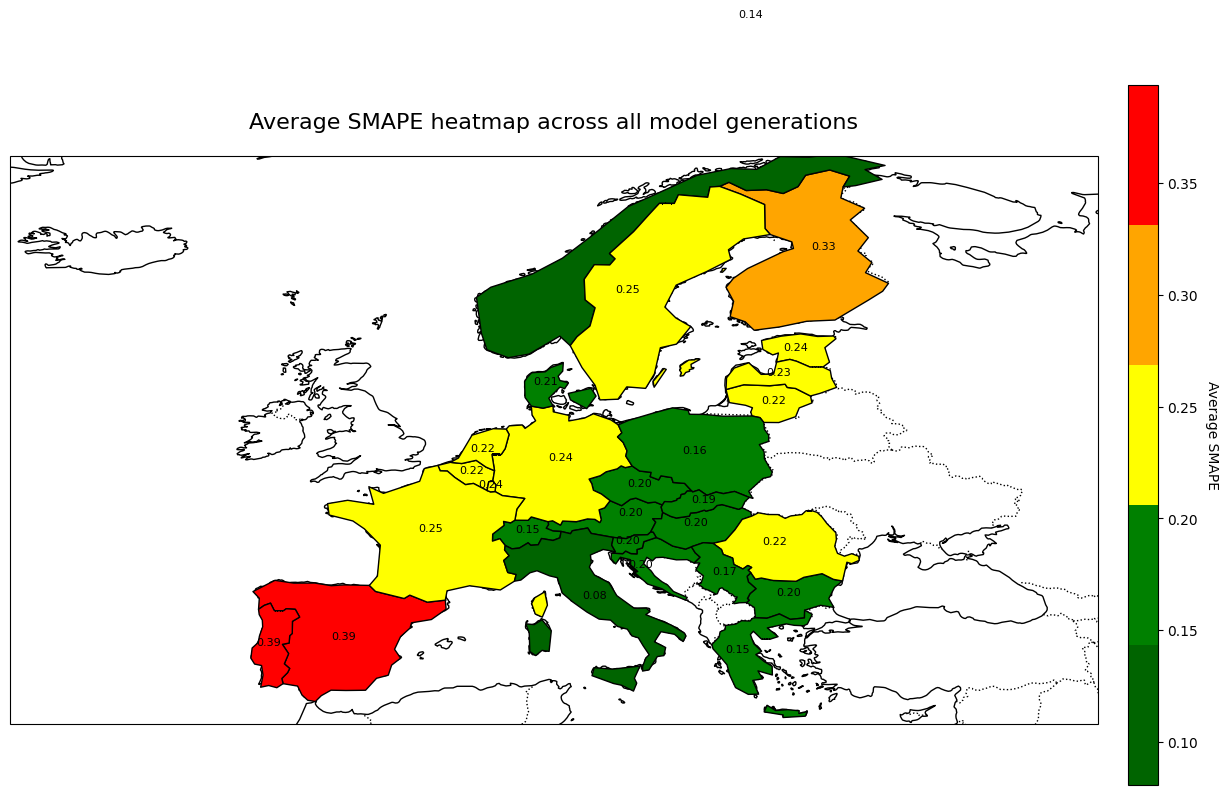

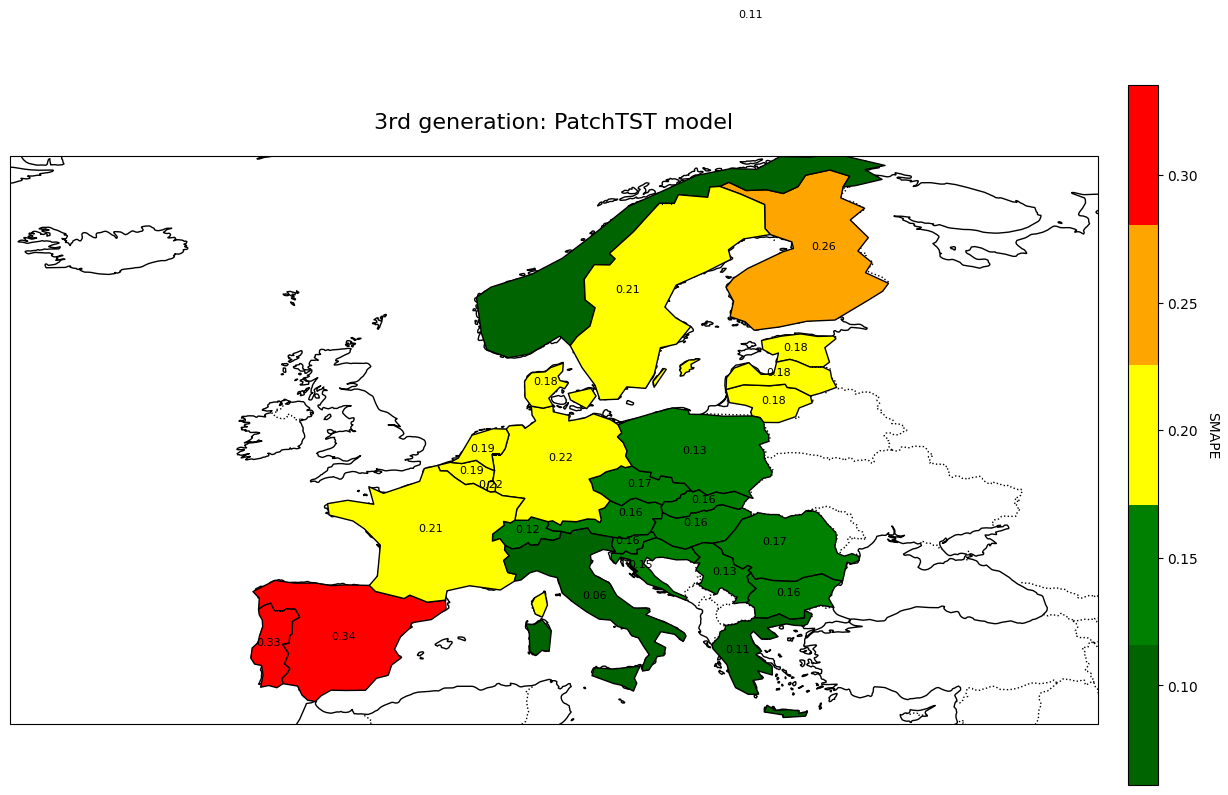

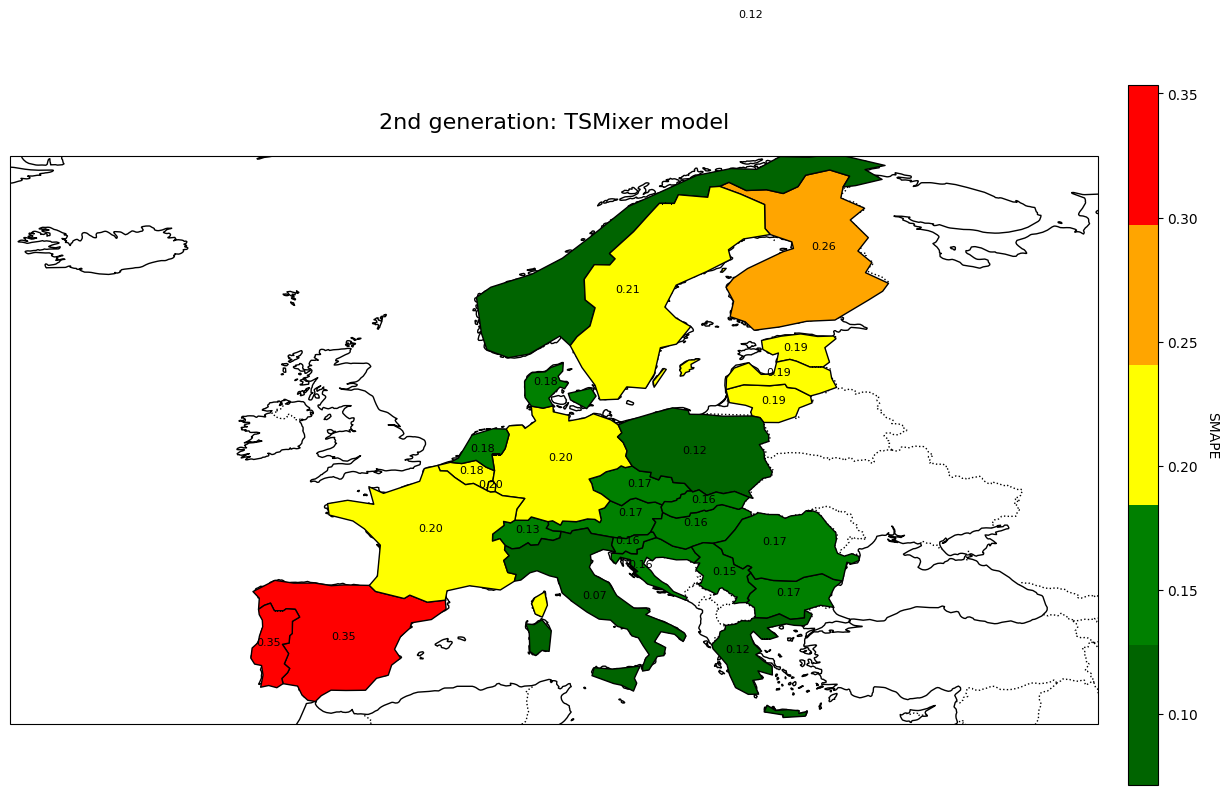

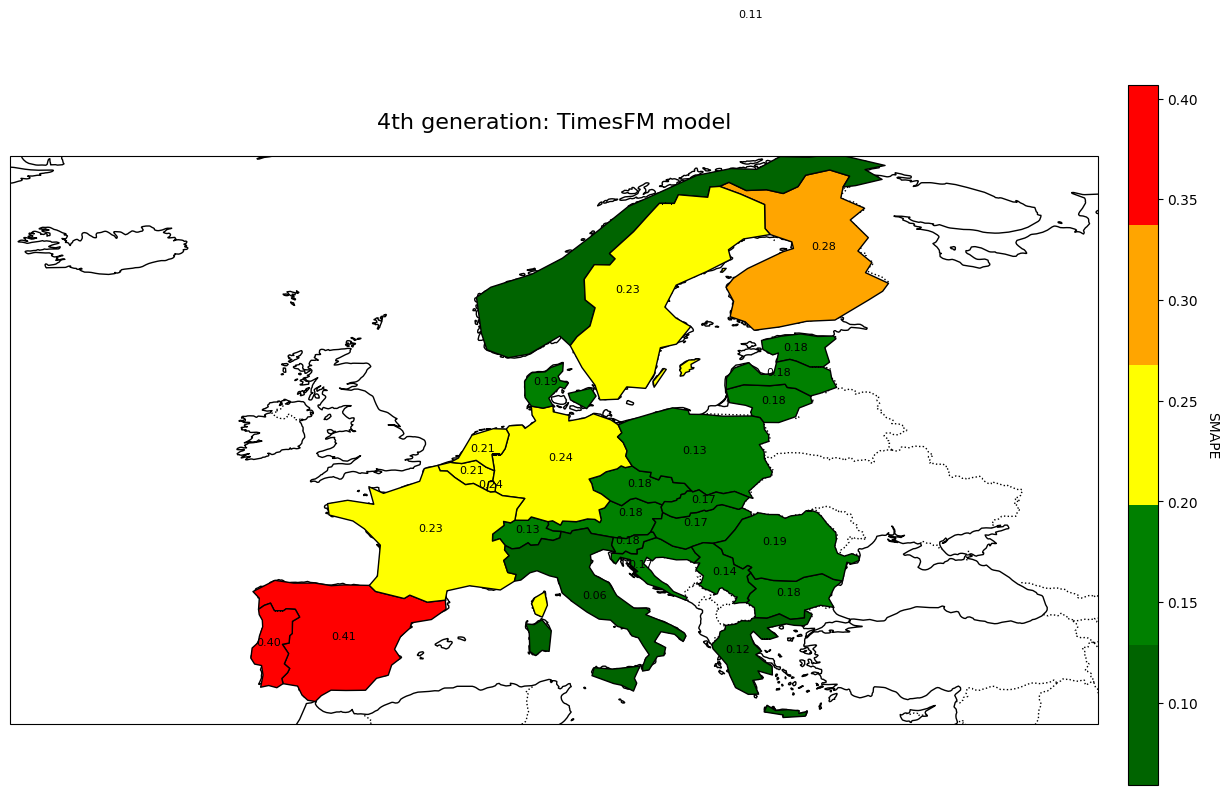

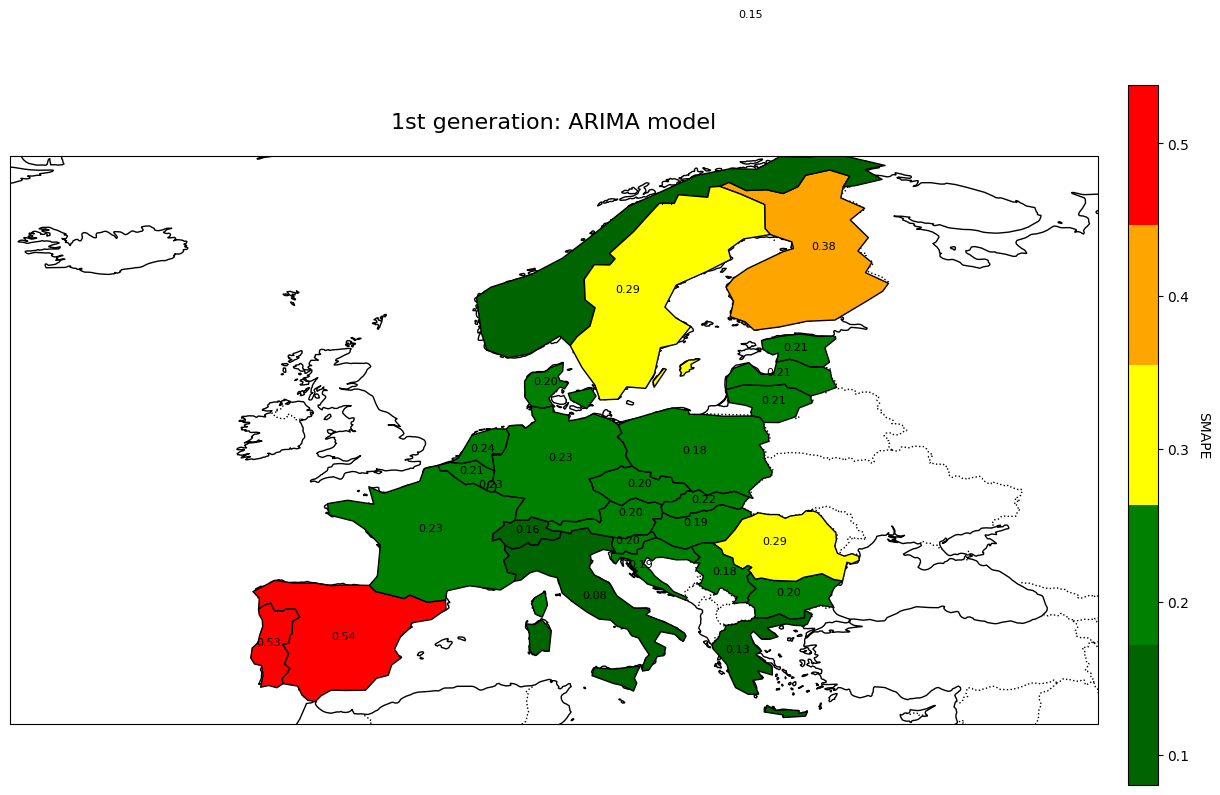

In [4]:
visualize_smape_geomaps(timeSeries_benchmark_results=timeSeries_benchmark_results)

- models to visualize with geo maps: PatchTST (3. generation best), TSMixer (2. generation best), TimesFM (4. generation best), ARIMA (the single model from 1. generation)

**2) Heatmaps with Performance per Model/Generation & per Country**

In [5]:
timeSeries_benchmark_results["Avg_Performance_Indicator"]=(timeSeries_benchmark_results["Achieved_RMSE"]+timeSeries_benchmark_results["Achieved_SMAPE"]*100)/2.0
ranking_table=timeSeries_benchmark_results.groupby(by=['EU_Country','Time_Series_Model'])['Avg_Performance_Indicator'].mean()
ranking_table=pd.DataFrame({'EU_Country':np.array([idx[0] for idx in ranking_table.index]),
                            'Time_Series_Model':np.array([idx[1] for idx in ranking_table.index]),
                            'Avg_Performance':ranking_table.values})

all_countries=ranking_table["EU_Country"].value_counts().keys()
best_models=[]
for country in all_countries:
    best_models.append(ranking_table[ranking_table["EU_Country"]==country].sort_values(by="Avg_Performance",ascending=True)['Time_Series_Model'].values)
best_models=np.array(best_models)

ranking_table=pd.DataFrame({'EU_Country':all_countries,"1":best_models[:,0],
                            "2":best_models[:,1],"3":best_models[:,2],
                            "4":best_models[:,3],"5":best_models[:,4],
                           "6":best_models[:,5],"7":best_models[:,6],
                           "8":best_models[:,7],"9":best_models[:,8],"10":best_models[:,9],
                           "11":best_models[:,10]})



ranking_table.index=ranking_table['EU_Country']
ranking_table=ranking_table.drop(["EU_Country"],axis=1)
all_best_models=[]
all_best_models.extend(list(ranking_table["1"].value_counts().keys()))
all_best_models.extend(list(ranking_table["2"].value_counts().keys()))
all_best_models.extend(list(ranking_table["3"].value_counts().keys()))
all_best_models.extend(list(ranking_table["4"].value_counts().keys()))
all_best_models.extend(list(ranking_table["5"].value_counts().keys()))
all_best_models.extend(list(ranking_table["6"].value_counts().keys()))
all_best_models.extend(list(ranking_table["7"].value_counts().keys()))
all_best_models.extend(list(ranking_table["8"].value_counts().keys()))
all_best_models.extend(list(ranking_table["9"].value_counts().keys()))
all_best_models.extend(list(ranking_table["10"].value_counts().keys()))
all_best_models.extend(list(ranking_table["11"].value_counts().keys()))

all_best_models=np.unique(all_best_models)

all_ranks=[]
for row_idx in range(0,ranking_table.shape[0]):
    rank_indicators=[]
    for model_idx in range(0,11): 
        if ranking_table.iloc[row_idx,0]==all_best_models[model_idx]:
            rank_indicators.append(1)
        elif ranking_table.iloc[row_idx,1]==all_best_models[model_idx]:
            rank_indicators.append(2)
        elif ranking_table.iloc[row_idx,2]==all_best_models[model_idx]:
            rank_indicators.append(3)
        elif ranking_table.iloc[row_idx,3]==all_best_models[model_idx]:
            rank_indicators.append(4)
        elif ranking_table.iloc[row_idx,4]==all_best_models[model_idx]:
            rank_indicators.append(5)
        elif ranking_table.iloc[row_idx,5]==all_best_models[model_idx]:
            rank_indicators.append(6)
        elif ranking_table.iloc[row_idx,6]==all_best_models[model_idx]:
            rank_indicators.append(7)
        elif ranking_table.iloc[row_idx,7]==all_best_models[model_idx]:
            rank_indicators.append(8)
        elif ranking_table.iloc[row_idx,8]==all_best_models[model_idx]:
            rank_indicators.append(9)
        elif ranking_table.iloc[row_idx,9]==all_best_models[model_idx]:
            rank_indicators.append(10)
        else:# ranking_table.iloc[row_idx,10]==all_best_models[model_idx]:
            rank_indicators.append(11)
            
    all_ranks.append(rank_indicators)
all_ranks=pd.DataFrame(all_ranks)
all_ranks.index=ranking_table.index
all_ranks.columns=all_best_models

indices=np.around(all_ranks.mean(axis=0).sort_values(ascending=True),3).index
val=np.around(all_ranks.mean(axis=0).sort_values(ascending=True),3).values
ylim_values=[indices[val_idx]+' ('+str(val[val_idx])+')' for val_idx in range(0,len(val))]



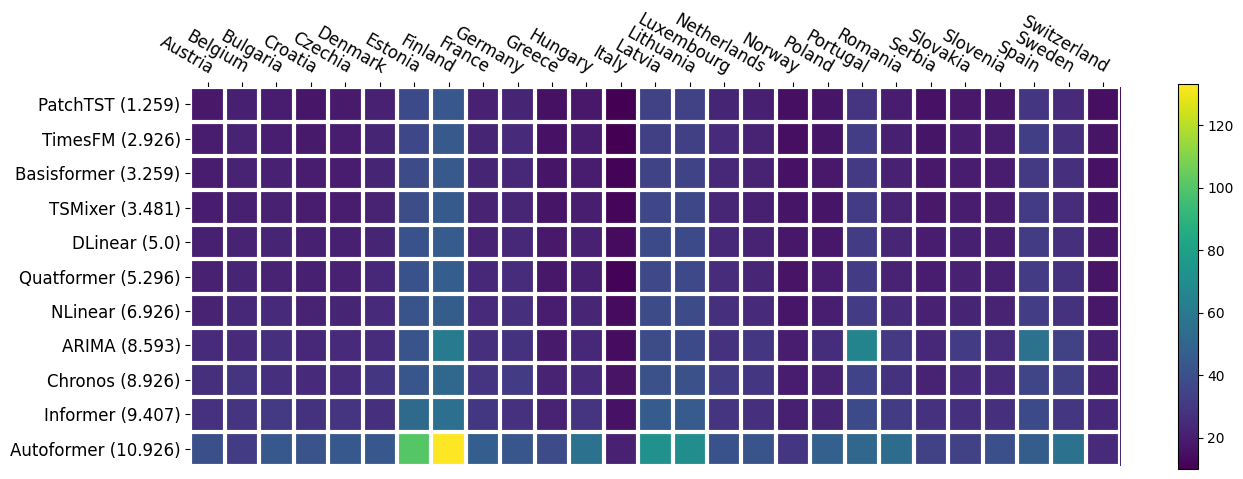

In [6]:
ranking_heatmap=timeSeries_benchmark_results.groupby(by=['EU_Country','Time_Series_Model'])['Avg_Performance_Indicator'].mean()
ranking_heatmap=pd.DataFrame({'EU_Country':np.array([idx[0] for idx in ranking_heatmap.index]),
                            'Time_Series_Model':np.array([idx[1] for idx in ranking_heatmap.index]),
                            'Avg_Performance':ranking_heatmap.values})
ranking_heatmap=ranking_heatmap.pivot(index='Time_Series_Model',columns='EU_Country',values='Avg_Performance')
ranking_heatmap=ranking_heatmap.reindex(indices)
ranking_heatmap.index=ylim_values


fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,5))
heatmap(data=ranking_heatmap,row_labels=ranking_heatmap.index,col_labels=ranking_heatmap.columns,ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
plt.close()



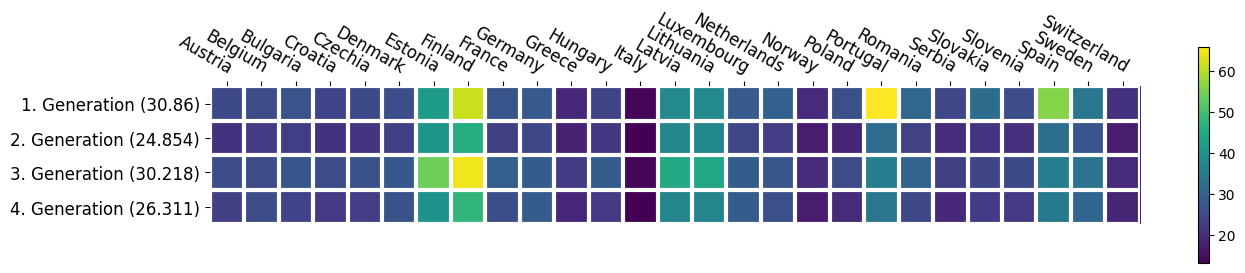

In [7]:
ts_models=timeSeries_benchmark_results['Time_Series_Model'].values
generations_ts_models=[]

for ts_model in ts_models:
    if ts_model=='ARIMA':
        generations_ts_models.append('1. Generation')
    elif ts_model in ['DLinear','NLinear','TSMixer']:
        generations_ts_models.append('2. Generation')
    elif ts_model in ['Autoformer','Basisformer','Informer','PatchTST','Quatformer']:
        generations_ts_models.append('3. Generation')
    else:
        generations_ts_models.append('4. Generation')
        
timeSeries_benchmark_results['Model_Generations']=np.array(generations_ts_models)

ranking_heatmap=timeSeries_benchmark_results.groupby(by=['EU_Country','Model_Generations'])['Avg_Performance_Indicator'].mean()
ranking_heatmap=pd.DataFrame({'EU_Country':np.array([idx[0] for idx in ranking_heatmap.index]),
                            'Model_Generations':np.array([idx[1] for idx in ranking_heatmap.index]),
                            'Avg_Performance':ranking_heatmap.values})
ranking_heatmap=ranking_heatmap.pivot(index='Model_Generations',columns='EU_Country',values='Avg_Performance')
rank_values=np.around(ranking_heatmap.mean(axis=1).values,3)
ranking_heatmap.index=[ranking_heatmap.index[avg_gen_rank_idx]+' ('+str(rank_values[avg_gen_rank_idx])+')' for avg_gen_rank_idx in range(0,len(rank_values))]

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,7))
heatmap(data=ranking_heatmap,row_labels=ranking_heatmap.index,col_labels=ranking_heatmap.columns,ax=ax,
       cbar_kw={"orientation": "vertical",
               'shrink':0.4})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
plt.close()


**3) Examining Model Rankings**

In [8]:
all_ranks

,ARIMA,Autoformer,Basisformer,Chronos,DLinear,Informer,NLinear,PatchTST,Quatformer,TSMixer,TimesFM
EU_Country,,,,,,,,,,,
Austria,8,11,3,9,5,10,7,1,6,2,4
Belgium,8,11,4,10,3,9,7,1,6,2,5
Bulgaria,8,11,3,9,6,10,7,1,5,4,2
Croatia,8,11,3,9,6,10,7,1,5,4,2
Czechia,8,11,3,9,5,10,7,1,6,4,2
Denmark,8,11,5,10,4,9,7,1,6,2,3
Estonia,7,11,3,9,5,10,8,2,6,4,1
Finland,10,11,3,8,5,9,6,1,7,4,2
France,8,11,4,9,3,10,7,1,6,2,5


In [9]:
print("Most frequent at 1. Rank: ",ranking_table["1"].value_counts().keys()[0])
print("Most frequent at 2. Rank: ",ranking_table["2"].value_counts().keys()[0])
print("Most frequent at 3. Rank: ",ranking_table["3"].value_counts().keys()[0])
print("Most frequent at 4. Rank: ",ranking_table["4"].value_counts().keys()[0])
print("Most frequent at 5. Rank: ",ranking_table["5"].value_counts().keys()[0])

Most frequent at 1. Rank:  PatchTST
Most frequent at 2. Rank:  TimesFM
Most frequent at 3. Rank:  Basisformer
Most frequent at 4. Rank:  TSMixer
Most frequent at 5. Rank:  DLinear


- Pairwise ranking test results:

In [10]:
heatmap_avg_res=timeSeries_benchmark_results.groupby(by=['EU_Country','Time_Series_Model'])['Avg_Performance_Indicator'].mean()
heatmap_avg_res=pd.DataFrame({'EU_Country':np.array([idx[0] for idx in heatmap_avg_res.index]),
                              'Time_Series_Model':np.array([idx[1] for idx in heatmap_avg_res.index]),
                              'Avg_Performance_Indicator':heatmap_avg_res.values})

heatmap_avg_res=heatmap_avg_res.pivot(index="Time_Series_Model",
                      columns="EU_Country",values="Avg_Performance_Indicator").T

models = ["ARIMA","PatchTST", "Autoformer", "Basisformer", "Chronos", "DLinear", "Informer", "NLinear", "Quatformer", "TSMixer", "TimesFM"]
countries=['Austria','Belgium','Bulgaria','Croatia','Czechia','Denmark','Estonia','Finland','France',
             'Germany','Greece','Hungary','Italy','Latvia','Lithuania','Luxembourg',
             'Netherlands','Norway','Poland','Portugal','Romania','Serbia',
              'Slovakia','Slovenia','Spain','Sweden','Switzerland']
    
smape_results=heatmap_avg_res
smape_data = {
     model: smape_results[model].tolist() for model in smape_results.columns
}

# Run the pairwise benchmarks
results = pairwise_benchmark_vs_patchtst_friedman_aligned(smape_data, models, countries)

# Interpret the results
alpha = 0.05
models_array=[]
p_values_array=[]
for _, row in results.iterrows():
    model = row["Compared Model"]
    p_value = row["Friedman Aligned P-value"]
    models_array.append(model)
    p_values_array.append(p_value)

p_val_frame=pd.DataFrame({"P-Values":np.array(p_values_array)})
p_val_frame.index=np.array(models_array)

print("P-Values from Friedman Pairwise Ranking Test: comparison against PatchTST")
p_val_frame["Avg_Model_Rank"]=all_ranks.mean(axis=0).values[np.where(all_ranks.mean(axis=0).index!="PatchTST")]
p_val_frame=p_val_frame.reindex(indices[1:])
p_val_frame

P-Values from Friedman Pairwise Ranking Test: comparison against PatchTST


,P-Values,Avg_Model_Rank
TimesFM,3.892417e-03,2.925926
Basisformer,2.034555e-07,3.259259
TSMixer,1.499876e-06,3.481481
DLinear,2.034555e-07,5.000000
Quatformer,2.034555e-07,5.296296
NLinear,2.034555e-07,6.925926
ARIMA,2.034555e-07,8.592593
Chronos,2.034555e-07,8.925926
Informer,2.034555e-07,9.407407
Autoformer,2.034555e-07,10.925926


**4) Robustness Analysis of top five best performing Models**
- boxplots for analyzing outliers and also for analyzing the performance across test subsets (walk-forward validation)
- classical time series plots to explain outliers in boxplots based on Germany

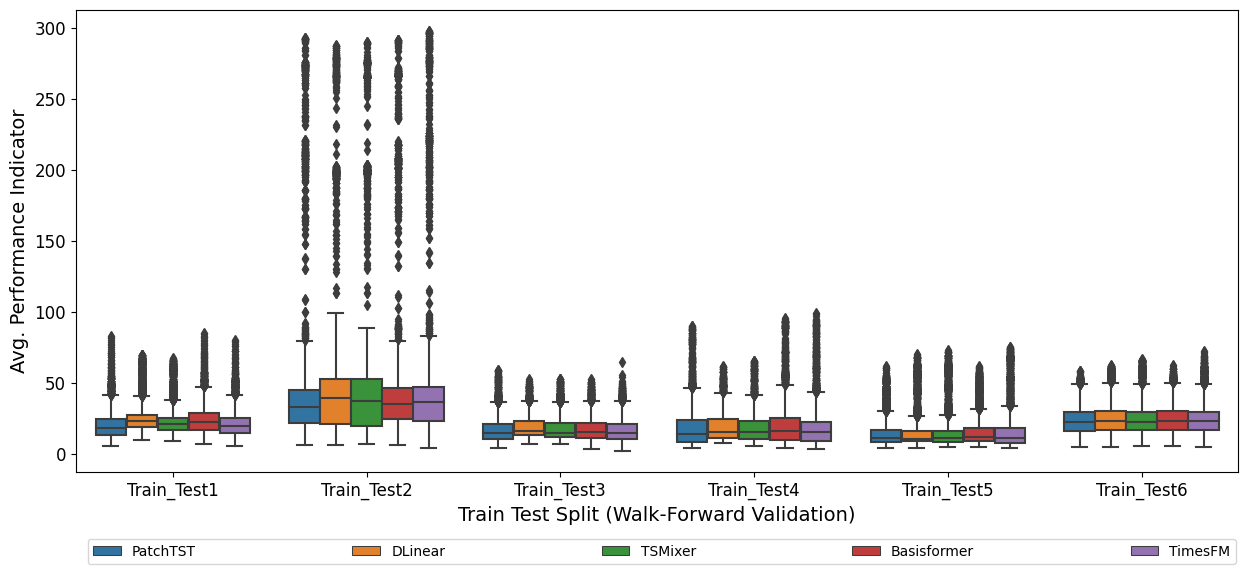

In [11]:
#Boxplot for analyzing outliers: #########################
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,6))
seaborn.boxplot(data=timeSeries_benchmark_results[timeSeries_benchmark_results["Time_Series_Model"].isin(["PatchTST","TimesFM",
                                                                                                          "Basisformer","TSMixer","DLinear"])],
                x="TrainTest_Subset",y='Avg_Performance_Indicator',ax=ax,hue="Time_Series_Model")
plt.legend(mode="expand",ncol=5,loc=[0.01,-0.2],fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Train Test Split (Walk-Forward Validation)",fontsize=14)
plt.ylabel("Avg. Performance Indicator",fontsize=14)

plt.show()
plt.close()
##########################################################

The top five performing models appear to deliver comparable results across the test subsets, with the exception of the second test subset. On the latter, the IQR range of the boxplots shows higher spread of the achieved error, and the extreme outliers indicate that the models are struggling with the predictions on this specific subset. In the following, we analyze the results obtained on Germany by comparing the the predictions on the first, second and last test subset. The reason for choosing Germany as an example is that it is one of the countries associated with moderate forecastability compared to other countries included in our research. (in simple terms: the models do not deliver neither the best, nor the worst results on Germany)

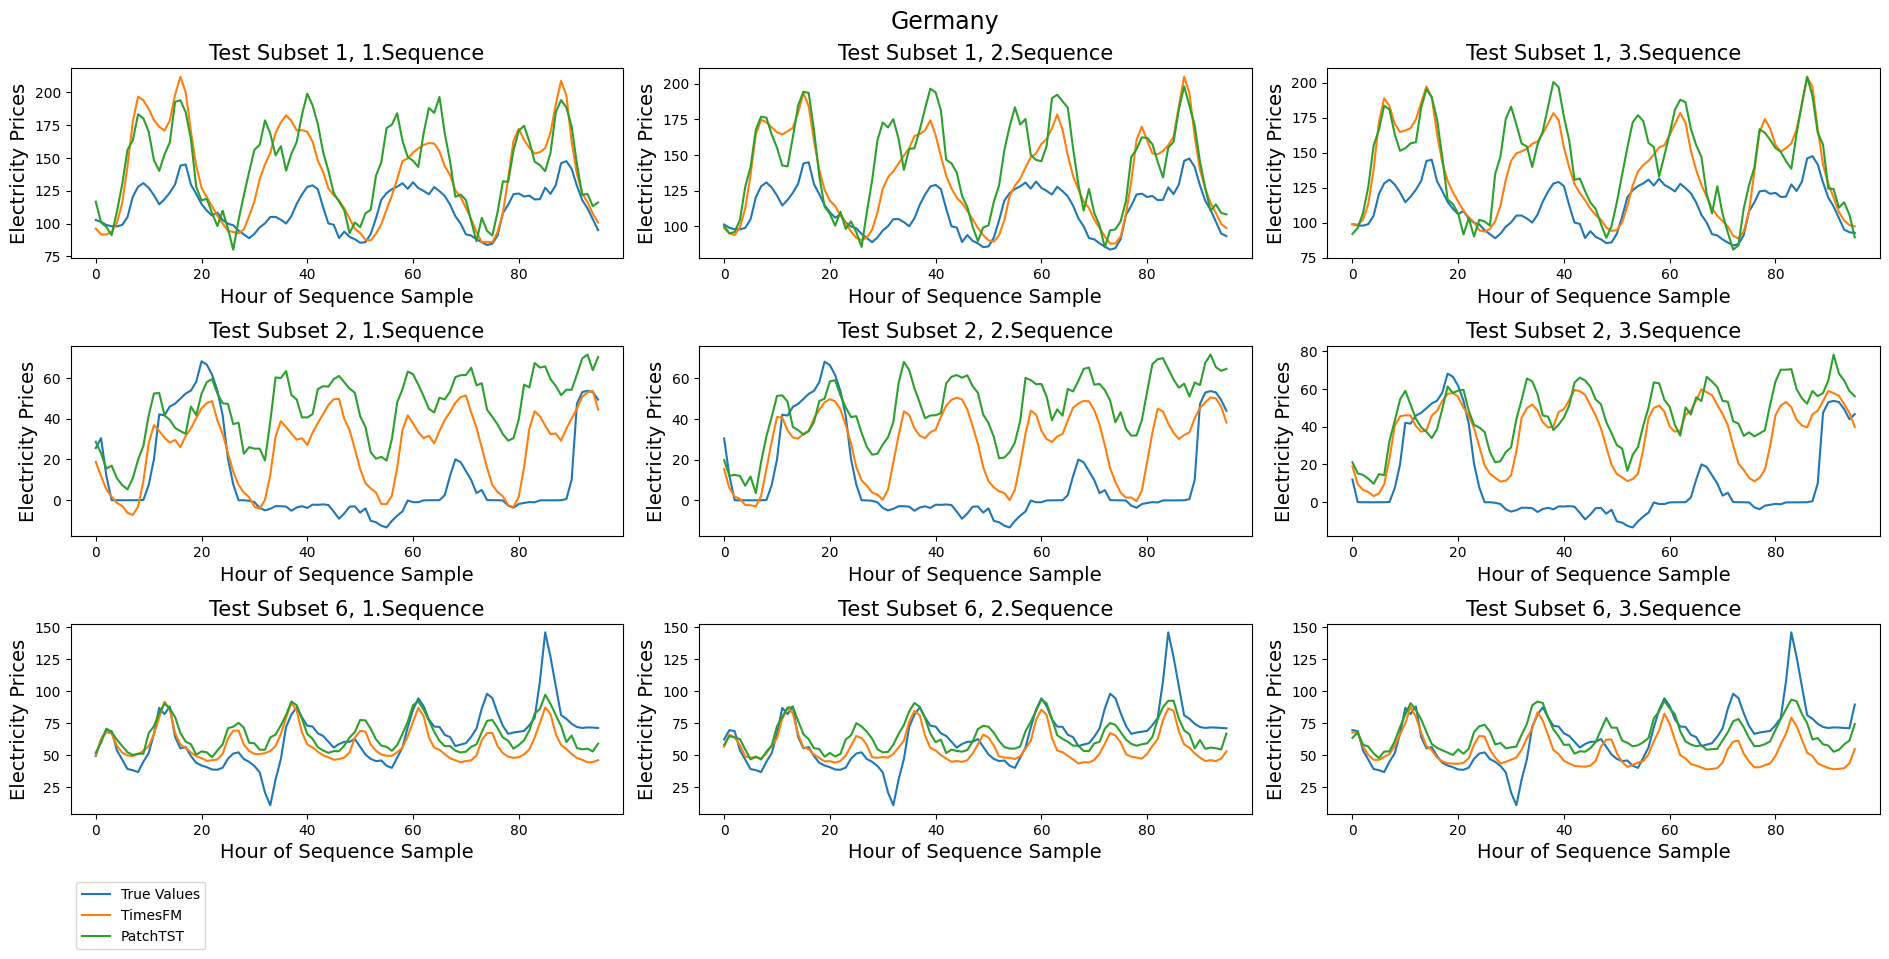

In [12]:
predictions_germany=sequence_predictions["Germany"]
predictions_france=sequence_predictions["France"]
predictions_latvia=sequence_predictions["Latvia"]
predictions_luxembourg=sequence_predictions["Luxembourg"]
fig,ax=plt.subplots(nrows=3,#len(predictions_germany[model_to_plot].keys()),
                    ncols=3,figsize=(19,10))
fig.suptitle("Germany",fontsize=17)
for subset_idx in ["Train_Test1","Train_Test2","Train_Test6"]:
#for model_to_plot in ["TimesFM","PatchTST"]:

    

    #for subset_idx in ["Train_Test1","Train_Test2","Train_Test6"]:#predictions_germany[model_to_plot].keys():
        #First Sequence:
    row_idx=(int(subset_idx[-1])-1 if subset_idx=="Train_Test1" else (1 if subset_idx=="Train_Test2" else 2))
    ax[row_idx,0].plot(predictions_germany["TimesFM"][subset_idx][0]["True"],
                                     label="True Values")
    ax[row_idx,0].plot(predictions_germany["TimesFM"][subset_idx][0]["Predicted"],
             label="TimesFM")
    ax[row_idx,0].plot(predictions_germany["PatchTST"][subset_idx][0]["Predicted"],
             label="PatchTST")
    ax[row_idx,0].set_title("Test Subset "+subset_idx[-1]+", 1.Sequence",fontsize=15)
    ax[row_idx,0].set_ylabel("Electricity Prices",fontsize=14)
    ax[row_idx,0].set_xlabel("Hour of Sequence Sample",fontsize=14)
    if subset_idx=="Train_Test6":
         ax[row_idx,0].legend(loc=[0.01,-0.71])
    
    #Second Sequence:
    ax[row_idx,1].plot(predictions_germany["TimesFM"][subset_idx][1]["True"],
                                     label="True Values")
    ax[row_idx,1].plot(predictions_germany["TimesFM"][subset_idx][1]["Predicted"],
             label="TimesFM")
    ax[row_idx,1].plot(predictions_germany["PatchTST"][subset_idx][1]["Predicted"],
             label="PatchTST")
    ax[row_idx,1].set_title("Test Subset "+subset_idx[-1]+", 2.Sequence",fontsize=15)
    ax[row_idx,1].set_ylabel("Electricity Prices",fontsize=14)
    ax[row_idx,1].set_xlabel("Hour of Sequence Sample",fontsize=14)
    

    #Third Sequence:
    ax[row_idx,2].plot(predictions_germany["TimesFM"][subset_idx][2]["True"],
                                     label="True Values")
    ax[row_idx,2].plot(predictions_germany["TimesFM"][subset_idx][2]["Predicted"],
             label="TimesFM")
    ax[row_idx,2].plot(predictions_germany["PatchTST"][subset_idx][2]["Predicted"],
             label="PatchTST")
    ax[row_idx,2].set_title("Test Subset "+subset_idx[-1]+", 3.Sequence",fontsize=15)
    ax[row_idx,2].set_ylabel("Electricity Prices",fontsize=14)
    ax[row_idx,2].set_xlabel("Hour of Sequence Sample",fontsize=14)
    

fig.tight_layout()
plt.show()
plt.close()

The time series plots clearly show that TimesFM and PatchTST perform poorly on the second subset due to not being able to capture sudden drops in the value of the electricity prices. In contrast to the second test subset, the predictions on the last subset are significantly more accurate. Therefore, in the abscence of sudden price drops, when the true electricity prices follow a rather repetitive/seasonal pattern, TimesFM and PatchTST manage to capture the overall dynmics of the electricity prices within the next 96 time steps.